In [1]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial, wraps 
import time
import random
    
from Setup_Functions import *
from Class_Structures import *
from Individual import * 
from InterObject import * 
from Global import * 
from Metrics import * 
from Tertiary import * 

load_dotenv("hidden.env") ## IMPORTANT: create a file (hidden.env) with your OpenAI API key 

True

## Set the Prompt 

In [2]:
scene_descriptor = "A bedroom that is 4m x 5m."

In [3]:
## Set up the API calls 
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}', 
    'Content-Type': 'application/json',
        }


# ## Read in all of the files to be used in the taskimport os
file_path1 = os.path.join("BlankConstraints", "Setup_Functions.py")
with open(file_path1, 'r') as file:
    file_contents1 = file.read()

file_path2 = os.path.join("BlankConstraints", "Individual.py")
with open(file_path2, 'r') as file:
    file_contents2 = file.read()

file_path3 = os.path.join("BlankConstraints", "InterObject.py")
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

file_path4 = os.path.join("BlankConstraints", "Tertiary.py")
with open(file_path4, 'r') as file:
    file_contents4 = file.read()

def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for i in range(len(lines)):

        line = lines[i]
        if line not in unique_lines: 
            unique_lines.append(line)
    return("\n").join(unique_lines)

def check_and_call(func_name, *args, **kwargs):
    """
    Calls the function with the given name if it exists in the global namespace.
    Returns the function's result or 0 if the function does not exist.
    """
    
    if func_name in globals() and callable(globals()[func_name]):
        return globals()[func_name](*args, **kwargs)
    else:
        return 0

def check_calls_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        return result
    return wrapper

def call_openai(prompt): 
    """Helper function to call OpenAI's API and return the response content."""
    # Define the request payload
    data = {
        "model": "gpt-4o",
        "messages": [{"role": "user", "content": prompt}]
        }
    # Make the API call
    response = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response.status_code == 200:
        response_data = response.json()
        if "```python" in response_data['choices'][0]['message']['content']:
            response = (response_data['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        elif "```" in response_data['choices'][0]['message']['content']:
            response = (response_data['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        else: 
            response = response_data['choices'][0]['message']['content']
        return response
    else:
        print('Failed to get a response', response.text)
        return 
    


# Set up the Room (all dimensions + fixed features)

In [4]:
start_time = time.time() # Start the time

### Run the room set up calls (LangPrompt1, Prompt1)

In [5]:
lang_prompt1 = """ I am designing the layout for a """ +  scene_descriptor + """. Give me the dimensions of the room, as well as the number of windows, 
doors, and sockets (only add sockets and windows if its appropriate). For each of these, tell me the dimensions in meters, which wall it should be on, as well as where on the wall it should 
be (a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: 
{Room: width = 5, length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}. The windows and doors should all 
have length 0.1. Ensure that every object has dimensions, position, and wall. No other text please. Just the list with no commentary or explanation.
"""

lang1output = call_openai(lang_prompt1)
objects = lang1output.split("}, {") if lang1output else []


prompt1 = """The functions in the following file are used to create a room and out objects in it: """ + file_contents1 + """. The room is described 
as """ +  scene_descriptor + """. For every element in this list, """ + str(objects) + """, translate it into a function call using the file attached.
For example, given the room descriptor 'a small kitchen' as well as the list: {Room: width = 5, length = 6}, 
{Object type: window, Number: 1, width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:
kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3). Return only the python script. 
No other text. Please ensure the correct number of inputs are given for each function."""


response1 = call_openai(prompt1)

## Account for any additional function calls (of other functions) by only taking the lines in the code that are relevant to the task   
lines = response1.split("\n")
response1 = [i for i in lines if 'create_room' in i]
## If the room is not defined properly, correct it
for line in response1: 
    if '=' not in line: 
        response1 = ['room = ' + line]
for line in lines[1:]: 
    if "create_fixed_object" in line: 
        response1.append(line)

response1 = ("\n").join(response1)

width = (response1.split("create_room("))[1].split(",")[0]
length = (response1.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = (response1.split("create_room("))[0].split("=")[0].strip()

lang_prompt2 = """ I am designing the layout of a """ + scene_descriptor + " that is " + width + "m x " + length + """m. Interior designers
suggest that a good layout will have different regions in the room for different functions. What regions should I use, and how many regions 
(minimum is 1 region - small rooms, e.g. 3x3, 2x3, etc, should only have 1 region, small medium sized rooms will have 2, 3x4, 4x3, 4x4, medium will have 3, etc) 
should there be based on the description, as well as the size of the room. Make sure to not add too many regions as this causes overcrowding 
(very few rooms will have more than 4 regions). Return this as a simple bullet list of regions to 
include. Return these in list of priority order. Do NOT add too many regions.
Only return the list of regions. No other information please."""

lang2output = call_openai(lang_prompt2)

prompt2 = "Given the room name: " + room_name + ", and the regions: " + lang2output +  """, using the function region_setup defined below, 
initialise each region. For example 'eating region' might output 'region_setup(kitchen, 'eating', 0). Where possible the region name ('eating') should be 
only one word. No other text please, 
only the python script. Don't include the function in the output. The function is: 
def region_setup(room_name, name, index):
    '''A function that initialises the regions in a room randomly.
        Inputs:
        room_name: Room obj (this should be the name of the room)
        name: str, the name of the region e.g 'sleeping'
        index: int, the index of the region (0, 1, 2, ...). First one must be 0, and the rest must be in order.
    '''
    return
"""

response2 = call_openai(prompt2)
global_context = globals().copy()
local_context = {}  
exec(response1 + "\n" + response2.replace("'" + room_name + "'", room_name), global_context, local_context)

fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

region_names = ""
list_region_names = []
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
        list_region_names.append(local_context[room_name].regions[i].name)  
    else: 
        region_names += local_context[room_name].regions[i].name + "."
        list_region_names.append(local_context[room_name].regions[i].name)
num_primary_objects = len(list_region_names)
num_regions = len(list_region_names)

if "'" + room_name + "'" in response2:
    response2 = response2.replace("'" + room_name + "'", "local_context[room_name]")
elif '"' + room_name + '"' in response2:
    response2 = response2.replace('"' + room_name + '"', "local_context[room_name]")
else: 
    response2 = response2.replace(room_name, "local_context[room_name]")


In [6]:
print(response1)
print(list_region_names)

bedroom = create_room(4, 5)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'north', position=0.4)
create_fixed_object(bedroom, 'window', 1.2, 0.1, 'south', position=0.7)
create_fixed_object(bedroom, 'door', 0.8, 0.1, 'east', position=0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position=0.5)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position=0.8)
['sleeping', 'storage', 'study']


# Get the primary objects, as well as all of their constraints. 

In [7]:
lang_prompt3 = f"""The room is described as {scene_descriptor}. Now for each one of the regions: {region_names}, 
what is the most important object to include (keep in mind the room description), and what are its dimensions (give width of back of object and length of side of object but not height) 
in meters. ONLY one object per region. Don't include any objects that go on the walls, e.g. wall art, and don't include any rugs/mats. The size of the room is {width} m x {length}m, bear this in mind when choosing the objects and the size 
of the objects (i.e. put small objects in small rooms). Give no other information please."""

lang3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3output.choices[0].message.content)

lang_prompt4 = f"""For each of these objects: {lang3output.choices[0].message.content}, tell me all of the considerations and constraints
for its placement within the room described as {scene_descriptor}, with size: {str(width)}m x {str(length)}m + room_width  that depend only on fixed features in the room like walls, windows, doors, sockets, etc. 
and return these as a bullet list for each object. Include practical things like whether it should be against a wall, or which side should be accessible for use 
(most objects will need an accessible constraint e.g. front of wardrobe needs to be accessible - however very few objects need all of their sides to be accessible 
and very few need their back to be accessible.) or if its tall, maybe it shouldn't block a window, etc. Bear in mind the size of the room, for example if the room is 
large, then the front, left, and right of the bed should be accessible, but if the room is very small, maybe only one side of the bed needs to be accessible.
Only give these constraints and considerations, no other information. """
 
lang4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4output.choices[0].message.content)

lang_prompt5 = f"""Tell me all of the constraints and considerations between the objects in this list {lang3output.choices[0].message.content} that depend only on each other.
These objects are for different regions, so the constraints should only really be about them being away from each other or near each other, 
nothing more specific. For example, maybe a desk should not be close to a bed, etc. The room is described as {scene_descriptor}, with size: {str(width)} m x {str(length)} m
Only give the constraints and considerations between objects, no other information.."""

lang5output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=2000
    )

print(lang5output.choices[0].message.content)

Sleeping: Bed, 1.5m x 2m  
Storage: Wardrobe, 1.5m x 0.6m  
Study: Desk, 1.2m x 0.6m
**Sleeping: Bed, 1.5m x 2m**  
- Place against one wall to save space, preferably with the 2m side against the wall.  
- Ensure one long side is accessible for getting in and out of bed.  
- Avoid placing under a window to prevent drafts.  
- Consider accessibility to electrical sockets for charging devices.  
- Ensure it does not block any doors or windows.  

**Storage: Wardrobe, 1.5m x 0.6m**  
- Place against a wall for stability and to save space.  
- Ensure the front is accessible for opening doors/drawers.  
- Avoid placing in direct line of entry to the room to prevent obstruction.  
- Consider proximity to where clothing or items may be frequently used.  

**Study: Desk, 1.2m x 0.6m**  
- Place against a wall, ideally near a window for natural light.  
- Ensure the front is accessible for use of the desk chair.  
- Consider proximity to electrical sockets for powering devices.  
- Avoid blocki

# Get the Secondary objects, as well as all of their constraints

In [8]:
lang_prompt6 = f"""Given a room described as: {scene_descriptor}, with size:{str(width)}m x {str(length)} m with these regions within 
it: {region_names}, and these primary objects already in it: {lang3output.choices[0].message.content}, what other objects should be added in? 
Give me 0-3 objects per region (depending on the size of the room - fewer objects for smaller rooms, and more objects for larger room) that should be added 
into the room (so make sure they are the most appropriate/necessary objects for their regions). Ensure to add objects that are necessary,e.g. if there's a desk, always add a 
desk chair. Try not to give objects that are redundant, e.g. if there is a tv stand in the room, you don't need a media console.
Objects should be things like furniture or plants or other objects that sit on the floor.
For each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. There can be more than one of 
each object kind (eg. multiple dining chairs or multiple nightstands) so make sure to specify how many of each object. Make sure to also give the dimensions of every object in meters (width of the back 
of the object and length of the side of the object but NOT HEIGHT). Remove any objects that are not placed directly on the floor, e.g. table lamp,
and remove any objects that are mounted on the wall (e.g. paintings). Don't include rugs. 
Only give objects that get placed onto the floor. Give no other text in the response. 
Only the list of objects."""

lang6output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=1000
    )

print(lang6output.choices[0].message.content)

lang_prompt7 = f"""For each of these objects {lang6output.choices[0].message.content}, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc. (return these as a bullet list for each object). 
Include practical things like whether it should be against a wall and what side of the object (one of: left, right, back, front) or if it should be
against a wall, or which side should be accessible for use (Most objects will have an accessible constraint -
 this would be something like the wardrobe needs to be accessible from the front so that the doors can open, or the bed needs to be accessible from the sides
 - but only give necessary accessible constraints. If an object can have its side against something, then don't say its side needs to be accessible 
 e.g. for a nightstand, etc). The room is described as {scene_descriptor}. Don't include any constraints that depend on other objects. 
 Only give these constraints and considerations, no other information. """
lang7output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7output.choices[0].message.content)

lang_prompt8 = f"""Tell me all of the constraints and considerations between the objects in this list {lang6output.choices[0].message.content} as well as 
in this list {lang3output.choices[0].message.content}. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, back, front) 
if appropriate, or minimum/maximum distances between objects etc. The room is described as {scene_descriptor}.
Only give the constraints and considerations between objects, no other information."""

lang8output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt8}],
        max_tokens=2000
    )

print(lang8output.choices[0].message.content)

1. Sleeping:  
   - Nightstand, 0.5m x 0.4m  
   - Dresser, 1.0m x 0.5m  

2. Storage:  
   - Shoe rack, 0.8m x 0.3m  

3. Study:  
   - Desk chair, 0.5m x 0.5m
1. Nightstand, 0.5m x 0.4m:
   - Consider placing against a wall (back side).

2. Dresser, 1.0m x 0.5m:
   - Place against a wall (back side).
   - Front side should be accessible for use (to access drawers).

3. Shoe rack, 0.8m x 0.3m:
   - Consider placing against a wall (back side).
   - Front side should be accessible for use (to place or remove shoes).

4. Desk chair, 0.5m x 0.5m:
   - Should be placed in proximity to a desk.
   - Preferably near a wall socket (to allow for electronics usage at the desk).
   - Avoid placing directly in front of doors or windows to prevent obstruction.
   - Back side might be against a wall, but space should be left so it can be pulled out for use.
1. Sleeping:  
   - The left or right side of the Nightstand should be against the left or right side of the Bed.
   - The Dresser should be pla

# Get the Tertiary Objects (Decorations!)

In [9]:
lang_prompt9 = f"""Given a room described as: {scene_descriptor}, with size: {str(width)} m x {str(length)} m with these regions within 
it: {region_names}, and these objects already in it: {lang3output.choices[0].message.content} {lang6output.choices[0].message.content}, 
suggest any rugs or other decorations or objects (these are things that go on top of other objects) that should be placed in the room.
For example, a tv to go on the tv unit, a painting above the bed, a table lamp on the nightstand, or a chandelier over the dining table, a 
computer to go on the desk, etc. Don't give any furniture or objects that go on the floor (other than rugs).
Everything should either go on the wall, on the ceiling, or on top of a piece of furniture. Don't include curtains.
Tell me the dimensions of the objects (width and length not height - in meters). If it is a wall object, its length should be 0.1m. 
Tell me how they should be placed (with respect to one object. e.g. painting should be placed near the dining table or lamp should 
be placed on a nightstand). Don't give too many objects and don't include multi-object objects e.g. gallery walls or shelves. """

lang9output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt9}],
        max_tokens=1000
    )

print(lang9output.choices[0].message.content)

Certainly! Here are a few suggestions for decorations and objects that can enhance the room:

1. **Sleeping Area:**
   - **Table Lamp:** 0.2m x 0.2m. Place it on the nightstand.
   - **Painting:** 0.8m x 0.1m. Hang it above the bed.

2. **Storage Area:**
   - **Decorative Box:** 0.4m x 0.3m. Place it on top of the dresser for additional storage and aesthetics.

3. **Study Area:**
   - **Desk Organizer:** 0.3m x 0.2m. Place it on the desk to keep stationery and small items organized.
   - **Wall Clock:** 0.4m x 0.1m. Mount it on the wall above the desk for easy visibility while studying.

4. **General Area:**
   - **Rug:** 1.8m x 2.8m. Place it centrally in the room, ensuring it extends under the bed and desk area for added warmth and style.
   - **Ceiling Light Fixture:** 0.5m x 0.5m. Position it centrally on the ceiling to provide ample lighting for the entire room. 

These additions will enhance both the functionality and aesthetics of the bedroom.


# Cleaning of the Constraints

In [10]:
cleaning_prompt1 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should not block windows 
and doors, change this into 2 bullets - one for blocking doors, and one for blocking windows. Remove any constraints that have if statements, and any
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints: {lang4output.choices[0].message.content}"""

cleaning1output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt1}],
        max_tokens=2000
    )


cleaning_prompt2 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window.  If there is an "or" statement in the constraint, choose one of the options.Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints. Here is the list of constraints:{lang5output.choices[0].message.content}"""

cleaning2output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt2}],
        max_tokens=2000
    )

cleaning_prompt3 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window. If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. If there are constraints for objects to be accessible from all sides that are unnecessary, 
change them to be which sides you think ARE necessary. If there are constraints with "or" in them, choose between the options. 
Return the list of cleaned constraints.  Here is the list of constraints: {lang7output.choices[0].message.content}"""

cleaning3output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt3}],
        max_tokens=2000
    )


cleaning_prompt4 = f"""I am going to give you a list of constraints. I want you to merge any similar constraints and also remove any duplicate constraints. 
Each constraint should be simplified, so that it is said in the most basic terms. I also want you to remove any constraints that are contradictory e.g. should be near a window 
AND should be away from a window.  If there is an "or" statement in the constraint, choose one of the options. Finally, each bullet constraint should only specify one constraint. For example if there is a bullet point that says and object should be away 
from windows and doors, change this into 2 bullets - one for away from doors, and one for away from windows. Remove any constraints that have if statements, and any 
that involve height. Return the list of cleaned constraints. If there are constraints with "or" in them, choose between the options. 
Here is the list of constraints: {lang8output.choices[0].message.content}"""

cleaning4output = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": cleaning_prompt4}],
        max_tokens=2000
    )   


p_ind_cons = cleaning1output.choices[0].message.content
p_io_cons = cleaning2output.choices[0].message.content
s_ind_cons = cleaning3output.choices[0].message.content
s_io_cons = cleaning4output.choices[0].message.content

In [11]:
print(p_ind_cons)

Here are the cleaned constraints, simplified and with duplicates and contradictions removed:

**Sleeping: Bed, 1.5m x 2m**  
- Place against one wall to save space.  
- Ensure one long side is accessible for getting in and out of bed.  
- Ensure accessibility to electrical sockets for charging devices.  
- Ensure it does not block any doors.

**Storage: Wardrobe, 1.5m x 0.6m**  
- Place against a wall for stability and to save space.  
- Ensure the front is accessible for opening doors/drawers.  
- Avoid placing in direct line of entry to the room.  
- Consider proximity to where clothing or items may be frequently used.

**Study: Desk, 1.2m x 0.6m**  
- Place against a wall.  
- Ensure the front is accessible for use of the desk chair.  
- Consider proximity to electrical sockets for powering devices.  
- Avoid blocking pathways.


In [12]:
print(p_io_cons)

Here is the cleaned list of constraints:

- The bed should have enough space around it for ease of access.
- Avoid placing objects too close to the sides of the bed.
- The wardrobe doors should be able to open fully without obstruction.
- Ensure there is enough clearance around the wardrobe.
- The desk should have a good source of light, either natural or artificial.
- The desk should not be placed directly next to the bed.
- Ensure there is a logical flow in the arrangement for easy movement.


In [13]:
print(s_ind_cons)

Here is the cleaned list of constraints:

1. Nightstand, 0.5m x 0.4m:
   - Place against a wall (back side).

2. Dresser, 1.0m x 0.5m:
   - Place against a wall (back side).
   - Front side should be accessible.

3. Shoe rack, 0.8m x 0.3m:
   - Place against a wall (back side).
   - Front side should be accessible.

4. Desk chair, 0.5m x 0.5m:
   - Place near a desk.
   - Preferably near a wall socket.
   - Avoid placing directly in front of doors.
   - Avoid placing directly in front of windows.
   - Allow space to pull out for use.


In [14]:
print(s_io_cons)

Here is the cleaned list of constraints:

1. Sleeping:
   - The Nightstand should be against the side of the Bed.
   - The Dresser should be placed with its back against a wall, not directly adjacent to the Bed, maintaining at least 0.5m of clearance.

2. Storage:
   - The Shoe rack should be placed with its back against a wall, not blocking pathways or access to other furniture.
   - The Wardrobe's back should be against a wall, with at least 0.6m clearance in front.

3. Study:
   - The Desk chair should have enough space to pull out, ideally at least 0.5m of clearance.
   - The Desk's back should be against a wall.

4. Overall spatial considerations:
   - Maintain clear pathways of at least 0.6m throughout the room for sufficient movement space.


# Add all the objects into the room 
### Region by region. 

In [15]:
prompt4 = f"""Given this list of primary objects: {lang3output.choices[0].message.content}, and this list of secondary objects: {lang6output.choices[0].message.content}, use the file attached to create the objects with the correct parameters.
The room name is: {room_name}, the region names are: {str(list_region_names)}. The room is already set up, only add in the objects using the 'create_moving_object' function. 
Ensure that each objects index is unique and that the indices begin from 0. The objects should be added in the correct regions. Add in all of the primary objects first.
This is the file: {file_contents1}. No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."""

response4 = call_openai(prompt4)     
lines = response4.split("\n")
response4_1 = []
for line in lines: 
    if "create_moving_object" in line: 
        response4_1.append(line)
response4_1 = ("\n").join(response4_1)

response4_1 = response4_1.replace("create_moving_object(room,", "create_moving_object(" + room_name + ",")
response4 = remove_identical_lines(response4_1).replace("(" + room_name, "(local_context[room_name]")

strings = response4.split("create_moving_object(local_context[room_name],")
primary_objects = []
for string in strings[1:]:
    if "'" in string: 
        primary_objects.append(string.split("'")[1])
    else:
        primary_objects.append(string.split('"')[1])

print(response4)

create_moving_object(local_context[room_name], 'bed', 1.5, 2.0, 'sleeping', 0)
create_moving_object(local_context[room_name], 'wardrobe', 1.5, 0.6, 'storage', 1)
create_moving_object(local_context[room_name], 'desk', 1.2, 0.6, 'study', 2)
create_moving_object(local_context[room_name], 'nightstand', 0.5, 0.4, 'sleeping', 3)
create_moving_object(local_context[room_name], 'dresser', 1.0, 0.5, 'sleeping', 4)
create_moving_object(local_context[room_name], 'shoe rack', 0.8, 0.3, 'storage', 5)
create_moving_object(local_context[room_name], 'desk chair', 0.5, 0.5, 'study', 6)


In [16]:
object_creations = ['' for i in range(num_regions + 1)]
lines = response4.split("\n")
for i in range(num_regions):
    sub_lines = [line for line in lines if "'" + list_region_names[i] + "'," in line or  '"' + list_region_names[i] + '",' in line]
    object_creations[0] = "\n".join([object_creations[0], sub_lines[0]])
    object_creations[i + 1] = "\n".join(sub_lines[1:])

primary_objects = []
secondary_objects = []
primary_object_indices = []

for name in list_region_names:
    lines = [i for i in response4.split("\n") if ((name + "'," in i or name + '",' in i) and 'create_moving_object' in i)]
    if "'" in lines[0]: 
        name = lines[0].split("'")[1]
    else:
        name = lines[0].split('"')[1]
    index = int(lines[0].split(", ")[-1].split(")")[0])
    primary_object_indices += [index]
    primary_objects += [name]

    for line in lines[1:]:
        if "'" in line: 
            name = line.split("'")[1]
        else:
            name = line.split('"')[1]
        secondary_objects += [name]

secondary_object_indices = [i for i in range(len(secondary_objects) + len(primary_objects)) if i not in primary_object_indices]

In [17]:
print(primary_object_indices, secondary_object_indices)
print(primary_objects, secondary_objects)

[0, 1, 2] [3, 4, 5, 6]
['bed', 'wardrobe', 'desk'] ['nightstand', 'dresser', 'shoe rack', 'desk chair']


# Find the Primary Optimization Functions

In [18]:
indent = '    '

In [19]:
def get_primary_function_calls():

    prompt5 = f"""Given the room_name {room_name} as well as the primary objects: {str(primary_objects)}, their 
    indices {str(primary_object_indices)} and these constraints: {p_ind_cons}, using the script attached, transform each constraint into a SINGLE 
    function call that will ensure that the primary objects are set up correctly. Match each constraint to the closest function in the
    script file by using the docstrings. Ensure that every constraint is mapped to a function call. Here is the first script: {file_contents2}. 
    For the second script, I want you to transform each pairwise constraint into a function call.
    Here is the second script: {file_contents3}, and here is the list of pairwise constraints: {p_io_cons}. I want 
    the output to begin with: def optimize_primary_objects(positions, room): \n output = 0,  followed by each constraint function call added to the output, 
    and then the output returned (everyline should begin with 'output +=' except for the final line). Go object by object, and then pairwise. 
    No extra text please, only the functions and the output. If there is only 1 primary object, there should be no pairwise calls.
    Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

    # Define the request payload
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt5}
                ]
        }
        
    # Make the API call
    response5 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response5.status_code == 200:
        response_data5 = response5.json()

        if "```" in response_data5['choices'][0]['message']['content']:
            list_objects = (response_data5['choices'][0]['message']['content']).split("\n")[1:-1]
            response5_1 = ""
            for i in range(len(list_objects)):
                response5_1 += list_objects[i] + "\n"
        else: 
            
            response5_1 = response_data5['choices'][0]['message']['content']

        response5 = remove_identical_lines(response5_1).replace("'''", "").replace("```", "")
        lines = response5.split("\n")
        new_lines = []
        for i in range(len(lines)): 
            if "ind_in_region" in lines[i]: 
                continue
            if "output" in lines[i]: 
                new_lines += [indent + "output" + lines[i].split("output")[1]]
                if '=' not in lines[i]: 
                    new_lines[-1] = indent + "\n"

            else: 
                new_lines += [lines[i]]
        
        response5 = ("\n").join(new_lines)
        whole_calls = [indent + "output += wall_attraction(positions, room)\n" + indent, "output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent, "output += 10*balanced(positions, room)\n" + indent + "return output"]
        new = response5.split("return")[0] 
        for call in whole_calls: 
            new += call 
        response5 = new

        lines = response5.split("\n")
        for line in lines[1:]: 
            if "ind_" in line or "io_" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        primary_function = ("\n").join(lines)
        print(primary_function)     
        
    else:
        print('Failed to get a response')
        primary_function = response5.text
    
    return primary_function

primary_function = get_primary_function_calls()
while ("ind_" not in primary_function or "io_" not in primary_function) and len(primary_object_indices) > 1:
    print("Failure to get individual AND inter object function calls. Rerunning.")
    primary_function = get_primary_function_calls()

def optimize_primary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_accessible', positions, room, 0, ['left'], 1.5)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket')
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 0, 'door')
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, ['front'])
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, 'door')
    output  += check_and_call('ind_near_wall', positions, room, 1, 'front', 0.6)
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    output  += check_and_call('ind_accessible', positions, room, 2, ['front'])
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 2, 'socket')
    output  += check_and_call('ind_away_from_fixed_o

In [20]:
primary_accessible_constraints = []
lines = primary_function.split("\n")
for line in lines: 
    if "ind_accessible" in line: 
        primary_accessible_constraints.append("output" + line.split("output")[1])

# Get the Secondary Optimization Functions

In [21]:
objects_per_region =[[] for i in range(num_regions)]
lines = response4.split("\n")
for i in range(len(lines)):
    for j in range(num_regions):
        if list_region_names[j] + "'," in lines[i] or list_region_names[j] + '",' in lines[i]:
            object_index = int(lines[i].split(", ")[-1].split(")")[0])
            objects_per_region[j].append(object_index)
        
object_regions = [list_region_names[k] for k in range(num_regions) for i in objects_per_region[k][1:]]
obj_ind = [(secondary_objects[i], secondary_object_indices[i], object_regions[i]) for i in range(len(secondary_objects))]


In [22]:
def get_secondary_function_calls():
    prompt6 = f"""Given the primary objects: {str(primary_objects)} and their indices: {str(primary_object_indices)}, as well as the secondary
    objects, along with their indices and their regions: {str(obj_ind)},  their individual 
    constraints: {s_ind_cons}, and these are the region names: {region_names}.  Using the script attached, transform each constraint into a SINGLE 
    function call that will ensure that the primary objects are set up correctly. Match each constraint to the closest function in the
    script file by using the docstrings. Ensure that every constraint is mapped to a function call.
    Here is the first script: {file_contents2}. For the second script, I want you to transform each pairwise constraint into a SINGLE function call. 
    Here is the second script: {file_contents3}, and here is the list of pairwise constraints: {s_io_cons}. 
    I want the output to begin with: ’def optimize_secondary_objects(positions, room): \n output = 0\n’, followed by each constraint function call 
    added to the output, (each line should begin with 'output +='). Go object by object, and then pairwise. 
    Also ensure to use ind_in_region for each object. Do not define ANY functions, only call them. No extra text please, only the functions and the output."""

    # Define the request payload.
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt6}
                ]
        }
        
    # Make the API call
    response6 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response6.status_code == 200:

        if "```" in response6.json()['choices'][0]['message']['content']:
            list_objects = (response6.json()['choices'][0]['message']['content']).split("\n")[1:-1]
            response6_1 = ""
            for i in range(len(list_objects)):
                response6_1 += list_objects[i] + "\n"
        else: 
            
            response6_1 = response6.json()['choices'][0]['message']['content']
        
        indent1 = (response6_1.split("output")[0]).split("\n")[-1]

        response6 = "def optimize_secondary_objects(positions, room):\n" + indent + "output = 0\n"
        response6 += indent + "\n" + (("\n").join((response6_1.split("return")[0]).split("\n")[2:])).replace(indent1, indent) + "\n" + indent + "return output \n"

        whole_calls = ["output += wall_attraction(positions, room)\n" + indent, "output += in_bounds(positions, room)\n" + indent, "output += no_overlap(positions, room)\n" + indent, "output += aligned(positions, room)\n" + indent + "return"]
        new = response6.split("return")[0] 
        for call in whole_calls: 
            new += call 
        new += response6.split("return")[1]
        response6 = new

        lines = response6.split("\n")
        for line in lines[1:]: 
            if "ind_" in line or "io_" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        response6 = ("\n").join(lines)
        print(response6)

    else:
        print('Failed to get a response')
        response6 = response6.text

    return response6, indent1

response6, indent1 = get_secondary_function_calls()
while "ind_" not in response6:
    print("Failure to get individual function calls. Rerunning.")
    response6, indent1  = get_secondary_function_calls()
while "io_" not in response6:
    print("Failure to get Inter Object function calls. Rerunning.")
    response6, indent1  = get_secondary_function_calls()


def optimize_secondary_objects(positions, room):
    output = 0
    
    # Individual Constraints
    output  += check_and_call('ind_next_to_wall', positions, room, 3)
    output  += check_and_call('ind_in_region', positions, room, 3, 'sleeping')
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_accessible', positions, room, 4, ['front'])
    output  += check_and_call('ind_in_region', positions, room, 4, 'sleeping')
    output  += check_and_call('ind_next_to_wall', positions, room, 5)
    output  += check_and_call('ind_accessible', positions, room, 5, ['front'])
    output  += check_and_call('ind_in_region', positions, room, 5, 'storage')
    output  += check_and_call('ind_next_to', positions, room, 6, 2)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 6, 'socket')
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 6, 'window')
    output  += check_and_call('ind_away_from_fixed_

In [23]:
secondary_functions = ['' for i in range(num_regions)]
lines = response6.split("\n")

for i in range(num_regions - 1, -1, -1):
    function = ("\n").join(lines[:2]) + "\n" + indent
    function += ("\n" + indent).join(primary_accessible_constraints[:i + 1])
        

    for obj_index in objects_per_region[i]:
        for line in lines: 
            if " " + str(obj_index) + "," in line or " " + str(obj_index) + ")" in line: 
                if line not in function:
                    function += "\n" + line
            
    for line in lines: 
        if "no_overlap" in line:
            function += "\n" + line
        if "in_bounds" in line:
            function += "\n" + line
        if "aligned" in line: 
            function += "\n" + line
        if "return" in line: 
            function += "\n" + line

    secondary_functions[i] =  function

In [24]:
for i in secondary_functions: 
    print(i)

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['left'], 1.5)
    output  += check_and_call('io_next_to', positions, room, 3, 0)
    output  += check_and_call('io_away_from', positions, room, 4, 0, 0.5)
    output  += check_and_call('io_away_from', positions, room, 5, 0, 0.6)
    output  += check_and_call('ind_next_to_wall', positions, room, 3)
    output  += check_and_call('ind_in_region', positions, room, 3, 'sleeping')
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_accessible', positions, room, 4, ['front'])
    output  += check_and_call('ind_in_region', positions, room, 4, 'sleeping')
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    return output 
def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', position

In [25]:
new_secondary_functions = secondary_functions.copy()
secondary_accessible_constraints = [[] for i in range(num_regions)]
for region in range(num_regions):
    for i in secondary_functions[region].split("\n"):
        if "ind_accessible" in i:
            secondary_accessible_constraints[region].append(("output" + i.split("output")[1]).replace(indent1, indent))

    secondary_accessible_constraints[region] = "\n" +("\n").join(secondary_accessible_constraints[region])

for i in range(num_regions):
    if i > 0: 
        for j in secondary_accessible_constraints[i - 1].split("\n"):
            if j not in secondary_accessible_constraints[i]:
                secondary_accessible_constraints[i] += ("\n" + j).replace(indent1, indent)

secondary_functions = new_secondary_functions.copy()

## Get the Tertiary Object Function

In [26]:
prompt7 = f"""Given this list of tertiary objects: {lang9output.choices[0].message.content} use the function attached to create the objects with the correct parameters.
The room name is: {room_name}. The room description is: {scene_descriptor}. The room is already set up, only add in the objects using the 'create_tertiary_object' function.
Ensure that each objects index is unique and that the indices begin from 0. The object names should be simple and short. The objects should be given the correct tertiary type 
(ceiling, floor, wall, or table). Wall objects should all have length 0.1m. Ensure that th parameters are set correctly. This is the function: """ + """
def create_tertiary_object(room, name, width, length, tertiary, index):
        " A function that creates and places a tertiary object 
        Inputs:
        room: Room for the object to be put in
        name: str, name of the object all lowercase. E.g. 'painting'
        width: float, width of the object (m)
        length: float, length of the object (m)
        tertiary: str, tertiary object type, one of "wall" (for objects that go on the wall e.g. painting),
                 "floor" (for objects that go on the floor e.g. rug), "ceiling" (for objects that go on the ceiling e.g. chandelier), 
                 "table" (for objects that go on a table e.g. lamp). 
        index: int, index of the object in the room's tertiary object list
    " """ 
prompt7 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt7}
            ]
    }
    
# Make the API call
response7 = requests.post(url, headers=headers, json=data)  
# Check the response
if response7.status_code == 200:
    response_data7 = response7.json()


    if "```" in response_data7['choices'][0]['message']['content']:
        list_objects = (response_data7['choices'][0]['message']['content']).split("\n")[1:-1]
        response7_1 = ""
        for i in range(len(list_objects)):
            response7_1 += list_objects[i] + "\n"
     
    lines = response_data7['choices'][0]['message']['content'].split("\n")
    response7_1 = []
    for line in lines: 
        if "create_tertiary_object" in line: 
            response7_1.append(line)
    response7_1 = ("\n").join(response7_1)
    
    response7_1 = response7_1.replace("create_tertiary_object(room,", "create_tertiary_object(" + room_name + ",")
    if "'" + room_name + "'" in response7_1:
        response7 = remove_identical_lines(response7_1).replace("'" + room_name + "'", 'local_context[room_name]')
    elif '"' + room_name + '"' in response7_1:
        response7 = remove_identical_lines(response7_1).replace('"' + room_name + '"', 'local_context[room_name]')
    elif room_name in response7_1:
        response7 = remove_identical_lines(response7_1).replace("(" + room_name, '(local_context[room_name]')

else:
    print('Failed to get a response')
    print(response7.text)

tertiary_indices = [i for i in range(len(response7.split("\n")))]
tertiary_objects = []
lines = response7.split("\n")
for line in lines:
    if "'" in line: 
        tertiary_objects.append(line.split("'")[1])
    else:
        tertiary_objects.append(line.split('"')[1])

print(response7)

create_tertiary_object(local_context[room_name], "lamp", 0.2, 0.2, "table", 0)
create_tertiary_object(local_context[room_name], "painting", 0.8, 0.1, "wall", 1)
create_tertiary_object(local_context[room_name], "box", 0.4, 0.3, "table", 2)
create_tertiary_object(local_context[room_name], "organizer", 0.3, 0.2, "table", 3)
create_tertiary_object(local_context[room_name], "clock", 0.4, 0.1, "wall", 4)
create_tertiary_object(local_context[room_name], "rug", 1.8, 2.8, "floor", 5)
create_tertiary_object(local_context[room_name], "light", 0.5, 0.5, "ceiling", 6)


In [27]:
tertiary_objects = []
lines = response7.split("\n")
for line in lines: 
    if '"' in line: 
        tertiary_objects.append(line.split('"')[1])
    else: 
        tertiary_objects.append(line.split("'")[1])
print(tertiary_objects)

['lamp', 'painting', 'box', 'organizer', 'clock', 'rug', 'light']


In [28]:
def get_tertiary_function_calls():
    prompt8 = f"""Given all the objects in the room: {str(primary_objects)} {str(secondary_objects)} and their indices: {str(primary_object_indices)} {str(secondary_object_indices)}
    as well as the region names: {region_names}. Here are the tertiary objects and how they should be placed: {str(tertiary_objects)} {lang9output.choices[0].message.content}.
    These are there indices: {str(tertiary_indices)}. Using the script attached, transform each placement into a SINGLE function call that will ensure that 
    the tertiary objects are placed correctly. If there is not a function that fits, then choose another. 
    Here is the  script: {file_contents4}. I want the output to begin with: ’def optimize_tertiary_objects(positions, room): \n output = 0\n’, followed by each function call 
    added to the output, (each line should begin with 'output +='). Do not define ANY functions, only call them. No extra text please, 
    only the functions and the output."""

    # Define the request payload.
    data = {
        "model": "gpt-4o",
        "messages": [
                {"role": "user", "content": prompt8}
                ]
        }
        
    # Make the API call
    response8 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response8.status_code == 200:

        if "```" in response8.json()['choices'][0]['message']['content']:
            list_objects = (response8.json()['choices'][0]['message']['content']).split("\n")[1:-1]
            response8_1 = ""
            for i in range(len(list_objects)):
                response8_1 += list_objects[i] + "\n"
        else: 
            
            response8_1 = response8.json()['choices'][0]['message']['content']
        
        indent1 = (response8_1.split("output")[0]).split("\n")[-1]

        response8 = "def optimize_tertiary_objects(positions, room):\n" + indent + "output = 0\n"
        response8 += indent + "\n" + (("\n").join((response8_1.split("return")[0]).split("\n")[2:])).replace(indent1, indent) + "\n" + indent + "return output \n"

        whole_calls = ["output += t_valid(positions, room)\n" + indent + "return"]
        new = response8.split("return")[0] 
        for call in whole_calls: 
            new += call 
        new += response8.split("return")[1]
        response8 = new

        lines = response8.split("\n")
        for line in lines[1:]: 
            if "positions" in line: 
                function_name = (line.split("(")[0]).split("= ")[1].strip()
                args = (line.split("(")[1]).split(")")[0]
                new_line = line.split("+=")[0] + " += check_and_call('" + function_name + "', " + args + ")"       
                lines[lines.index(line)] = new_line

        response8 = ("\n").join(lines)
        print(response8)

    else:
        print('Failed to get a response')
        response8 = response8.text

    return response8

response8 = get_tertiary_function_calls()
lines = response8.split("\n")
new_lines = []
for i in range(len(lines)): 
    if "output" in lines[i] or "def" in lines[i]: 
        new_lines.append(lines[i])
response8 = ("\n").join(new_lines)

def optimize_tertiary_objects(positions, room):
    output = 0
    
    output  += check_and_call('on_top_central', positions, room, 0, 3)
    output  += check_and_call('on_wall_near', positions, room, 1, 0)
    output  += check_and_call('on_top_central', positions, room, 2, 4)
    output  += check_and_call('on_top_central', positions, room, 3, 2)
    output  += check_and_call('on_wall_near', positions, room, 4, 2)
    output  += check_and_call('rug_under_central_forward', positions, room, 5, 0)
    output  += check_and_call('center_ceiling', positions, room, 6)

    output  += check_and_call('t_valid', positions, room)
    return output 



In [29]:
print(lang9output.choices[0].message.content)

Certainly! Here are a few suggestions for decorations and objects that can enhance the room:

1. **Sleeping Area:**
   - **Table Lamp:** 0.2m x 0.2m. Place it on the nightstand.
   - **Painting:** 0.8m x 0.1m. Hang it above the bed.

2. **Storage Area:**
   - **Decorative Box:** 0.4m x 0.3m. Place it on top of the dresser for additional storage and aesthetics.

3. **Study Area:**
   - **Desk Organizer:** 0.3m x 0.2m. Place it on the desk to keep stationery and small items organized.
   - **Wall Clock:** 0.4m x 0.1m. Mount it on the wall above the desk for easy visibility while studying.

4. **General Area:**
   - **Rug:** 1.8m x 2.8m. Place it centrally in the room, ensuring it extends under the bed and desk area for added warmth and style.
   - **Ceiling Light Fixture:** 0.5m x 0.5m. Position it centrally on the ceiling to provide ample lighting for the entire room. 

These additions will enhance both the functionality and aesthetics of the bedroom.


In [30]:
lang_prompt10 = f"""Given the description of the room: {scene_descriptor}, with size: {str(width)}m x {str(length)}m 
with these objects within it: {str(primary_objects)} {str(secondary_objects)} {str(tertiary_objects)}, tell me the colours of the walls 
and whether there should be wallpaper/paint/some other wall material. Tell me the style and colour of the windows and doors. 
Tell me the material and colour of the floor, and for each object, one by one, describe its colour, style, etc. 
Make sure that all of the objects are cohesive together and match the description of the room."""


STYLEoutput = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt10}],
        max_tokens=4096
    )

In [31]:
print(STYLEoutput.choices[0].message.content)

Designing a cohesive and aesthetically pleasing bedroom involves harmonizing the colors, materials, and styles of the walls, windows, doors, floor, and furniture. Here's a detailed description:

### **Walls:**
- **Color**: Soft sage green, which provides a calming and neutral backdrop that complements various furniture styles and colors.
- **Material**: Painted walls with the option of a feature wall adorned with a subtle botanical wallpaper to add texture and interest.

### **Windows and Doors:**
- **Windows**: 
  - **Style**: Large, modern, floor-to-ceiling with sleek black frames to offer a contemporary feel and allow plenty of natural light.
  - **Color**: Black frames with sheer white curtains to diffuse the sunlight beautifully.
- **Doors**:
  - **Style**: Simple paneled door.
  - **Color**: Soft white with black hardware to tie in with the window frames.

### **Floor:**
- **Material**: Light oak hardwood floor, which provides warmth and an inviting natural foundation for the roo

# Run the code !


Adding in the primary objects:  ['bed', 'wardrobe', 'desk']


/opt/anaconda3/envs/Flairgpt/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Iteration: 0
Cost:  13.908494350717689 5.441089483371803e-05 0.010664159885239118
Iteration: 2 , New best result found. Cost:  11.527711162224602
Iteration: 3 , New best result found. Cost:  5.133999374629654
Iteration: 6 , New best result found. Cost:  1.4787820495843609
Iteration: 50
Iteration: 58 , New best result found. Cost:  0.5568731828970478
Iteration: 100
Iteration: 139 , New best result found. Cost:  0.4650313184021204
Iteration: 150


/opt/anaconda3/envs/Flairgpt/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Iteration: 200
Iteration: 225 , New best result found. Cost:  0.43911967839655736
Iteration: 250
300


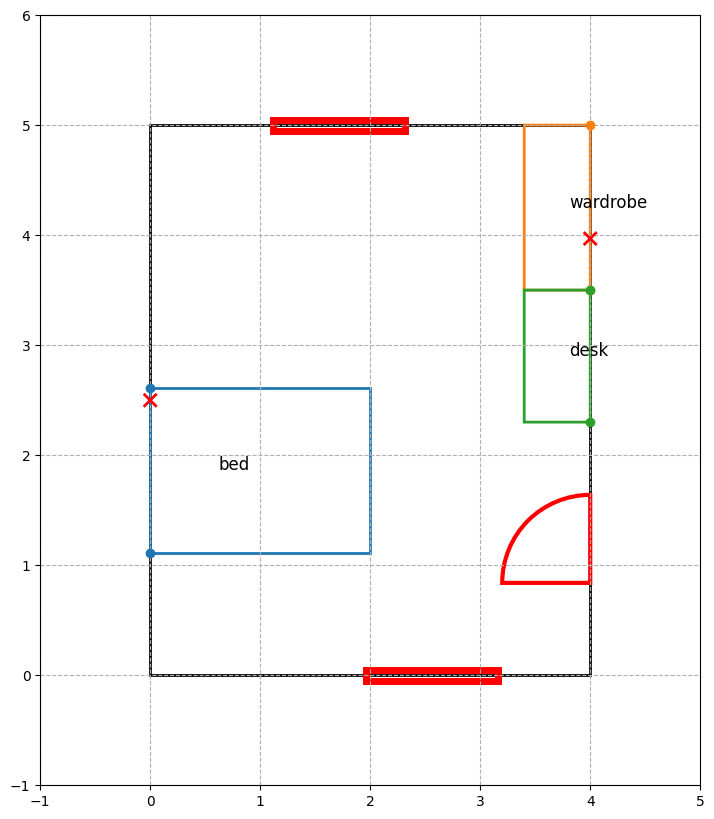

In [32]:
global_context = globals().copy()
local_context = {}
local_context2 = {}
exec(response1, global_context, local_context)

exec(primary_function, global_context, local_context) # define the very first optimizaton function 
## Now want to add in the first primary object
exec(response2) # add in the regions
exec(object_creations[0]) # add in the primary objecta
print("Adding in the primary objects: ", primary_objects)

options = {'maxiter': 200, 'ftol': 1e-6}
iters = 0
min_fun = np.inf
room = local_context[room_name]
func = local_context['optimize_primary_objects']
best_res = None
second_res = None
bounds = Bounds([-1, -1, -np.inf] * len(room.moving_objects), [room.width + 1, room.length + 1, np.inf] * len(room.moving_objects))
while min_fun > 1e-2 and iters < min(len(primary_objects)*100, 300):
    positions = np.zeros((len(room.moving_objects) - len(room.fm_indices)) * 3)
    for i in range(len(room.moving_objects) - len(room.fm_indices)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds) 

    if iters%50 == 0: 
        print("Iteration:", iters)
        if not best_res:
            print("Cost: ", res.fun, no_overlap(res.x, room), in_bounds(res.x, room))
    iters += 1
    if res.fun < min_fun:
        if not no_overlap(res.x, room) > 0.3 and not in_bounds(res.x, room) > 1e-2:
            min_fun = res.fun
            best_res = res
            print("Iteration:", iters, ", New best result found. Cost: ", min_fun)
    if not second_res:
        second_res = res
    elif second_res and ((res.fun <= second_res.fun) and (in_bounds(res.x, room) <= in_bounds(second_res.x, room) or no_overlap(res.x, room) <= no_overlap(second_res.x, room))): 
        second_res = res

print(iters)
if not best_res: 
    best_res = second_res

for i in range(len(room.fm_indices), len(room.moving_objects)): 
    j = i - len(room.fm_indices)
    room.moving_objects[i].position = (best_res.x[3*j], best_res.x[3*j + 1], best_res.x[3*j + 2]%(2*np.pi))
room.draw() 

for i in range(num_regions):
    room.regions[i].x, room.regions[i].y = room.moving_objects[i].position[0], room.moving_objects[i].position[1]


In [33]:
print(primary_function)

def optimize_primary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_next_to_wall', positions, room, 0)
    output  += check_and_call('ind_accessible', positions, room, 0, ['left'], 1.5)
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 0, 'socket')
    output  += check_and_call('ind_not_block_fixed_object', positions, room, 0, 'door')
    output  += check_and_call('ind_next_to_wall', positions, room, 1)
    output  += check_and_call('ind_accessible', positions, room, 1, ['front'])
    output  += check_and_call('ind_away_from_fixed_object', positions, room, 1, 'door')
    output  += check_and_call('ind_near_wall', positions, room, 1, 'front', 0.6)
    output  += check_and_call('ind_next_to_wall', positions, room, 2)
    output  += check_and_call('ind_accessible', positions, room, 2, ['front'])
    output  += check_and_call('ind_close_to_fixed_object', positions, room, 2, 'socket')
    output  += check_and_call('ind_away_from_fixed_o

In [34]:
for i in range(len(secondary_functions)):
    print(secondary_functions[i])

def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', positions, room, 0, ['left'], 1.5)
    output  += check_and_call('io_next_to', positions, room, 3, 0)
    output  += check_and_call('io_away_from', positions, room, 4, 0, 0.5)
    output  += check_and_call('io_away_from', positions, room, 5, 0, 0.6)
    output  += check_and_call('ind_next_to_wall', positions, room, 3)
    output  += check_and_call('ind_in_region', positions, room, 3, 'sleeping')
    output  += check_and_call('ind_next_to_wall', positions, room, 4)
    output  += check_and_call('ind_accessible', positions, room, 4, ['front'])
    output  += check_and_call('ind_in_region', positions, room, 4, 'sleeping')
    output += in_bounds(positions, room)
    output += no_overlap(positions, room)
    output += aligned(positions, room)
    return output 
def optimize_secondary_objects(positions, room):
    output = 0
    output  += check_and_call('ind_accessible', position

Adding in the secondary objects:  ['nightstand', 'dresser']
Iteration: 0
Cost:  9.580472200667392 3.4750091026175594 0.3405749058255772
Iteration 2 , New best result found. Cost:  3.3681687266141176 overlap:  0 bounds:  4.690605245485793e-05
Iteration 7 , New best result found. Cost:  3.368147412759447 overlap:  0 bounds:  4.708830420159129e-05
Iteration 14 , New best result found. Cost:  3.3681461024445922 overlap:  0 bounds:  4.6119848603872824e-05
Iteration: 50


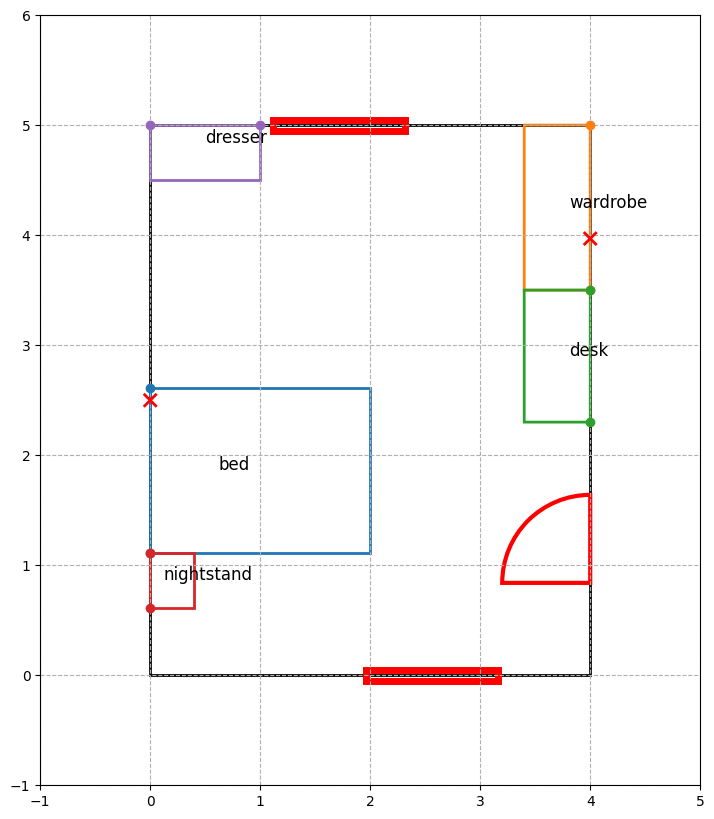

Adding in the secondary objects:  ['shoe rack']
Iteration: 0
Cost:  14.75790290844667 0 0.0836444722569882
Iteration 1 , New best result found. Cost:  14.75790290844667 overlap:  0 bounds:  0.0836444722569882
Iteration 2 , New best result found. Cost:  0.07818952810232137 overlap:  0 bounds:  4.6119848603872824e-05
Iteration 4 , New best result found. Cost:  0.07811922751706582 overlap:  0 bounds:  4.611984860697931e-05


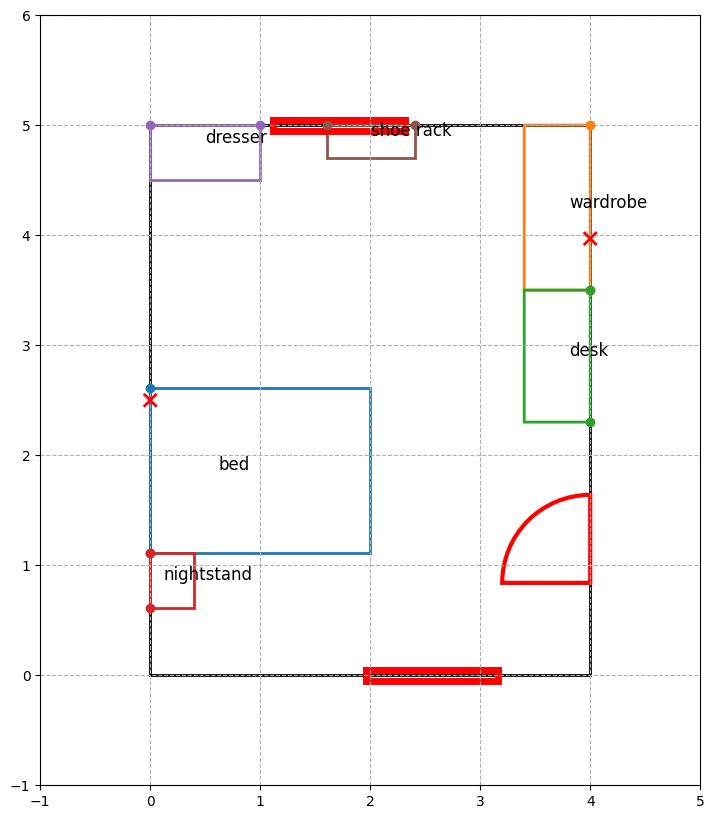

Adding in the secondary objects:  ['desk chair']
Iteration: 0
Cost:  3.730455622115363 0 4.611984860697931e-05
Iteration 1 , New best result found. Cost:  3.730455622115363 overlap:  0 bounds:  4.611984860697931e-05
Iteration 2 , New best result found. Cost:  3.6657557006851755 overlap:  0 bounds:  4.611984860697931e-05
Iteration 3 , New best result found. Cost:  2.9754729257499566 overlap:  0.12412375971941475 bounds:  4.611984860697931e-05
Iteration 34 , New best result found. Cost:  2.8373085427834486 overlap:  0.1389312777067206 bounds:  4.611984860697931e-05


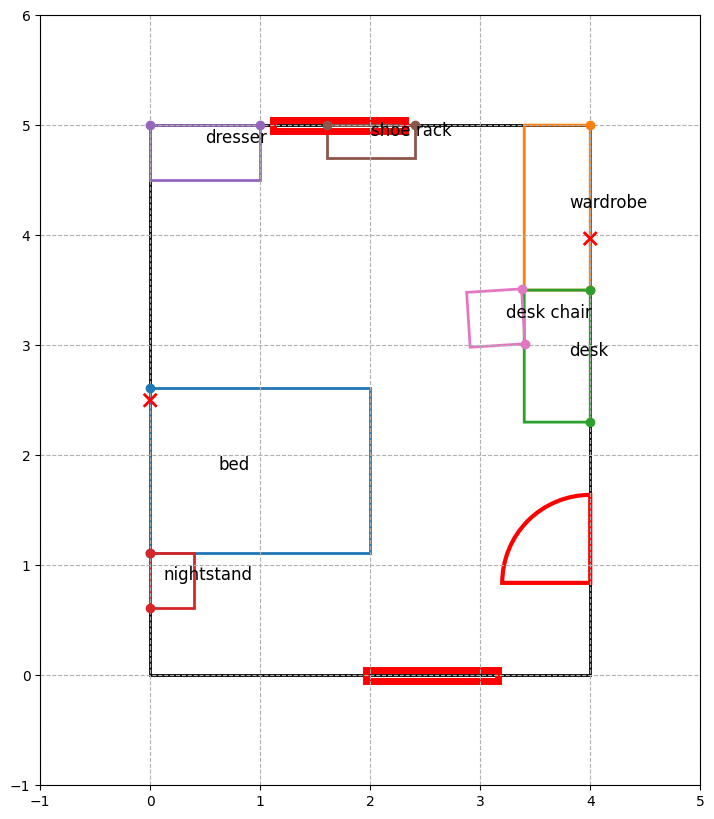

In [35]:
room.moving_objects = room.moving_objects[:num_primary_objects]
room.fm_indices = [i for i in range(num_primary_objects)]
room.tertiary_objects = []
options = {'maxiter': 200, 'ftol': 1e-8}

for region in range(num_regions):
    exec(object_creations[region + 1]) # add in the secondary objects for the region
    exec(secondary_functions[region], global_context, local_context) # define the optimization function for the secondary objects
    room = local_context[room_name]
    func = local_context['optimize_secondary_objects']
    
    print("Adding in the secondary objects: ", [room.moving_objects[i].name for i in objects_per_region[region]][1:])

    num = len(room.moving_objects) - len(room.fm_indices)
    bounds = Bounds([-1] * 3 * num, [room.width + 1, room.length + 1, np.inf] * num)
    iters = 0
    min_fun = np.inf
    best_res2 = None
    second_res = None
    while (min_fun > 1e-2 and best_res2 is None and iters < 400) or (best_res2 and iters < min(num*50, 300)):
        positions = np.zeros(3*num)
        for i in range(num):
            positions[3*i] = np.random.uniform(0, room.width)
            positions[3*i + 1] = np.random.uniform(0, room.length)
            positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
        res = minimize(func, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)

        if iters%50 == 0:
            print("Iteration:", iters)
            if not best_res2:
                print("Cost: ", res.fun, no_overlap(res.x, room), in_bounds(res.x, room))
        iters += 1
        if res.fun < min_fun:
            if not no_overlap(res.x, room) > 0.4 and not in_bounds(res.x, room) > 0.1:
                min_fun = res.fun 
                best_res2 = res
                print("Iteration", iters, ", New best result found. Cost: ", min_fun, "overlap: ", no_overlap(res.x, room), "bounds: ", in_bounds(res.x, room))
        if not second_res:
            second_res = res
        elif second_res and ((res.fun <= second_res.fun) and (in_bounds(res.x, room) <= in_bounds(second_res.x, room) or no_overlap(res.x, room) <= no_overlap(second_res.x, room))): 
            second_res = res
    
    if not best_res2: 
        best_res2 = second_res
  
    for i in range(len(room.fm_indices), len(room.moving_objects)): 
        j = i - len(room.fm_indices)
        room.moving_objects[i].position = (best_res2.x[3*j], best_res2.x[3*j + 1], best_res2.x[3*j + 2]%(2*np.pi))

    room.regions[region].x = np.mean([i.position[0] for i in room.moving_objects if i.region == list_region_names[region]])
    room.regions[region].y = np.mean([i.position[1] for i in room.moving_objects if i.region == list_region_names[region]])

    room.draw() 
    plt.show()
    room.fm_indices += [i for i in range(len(room.fm_indices), len(room.moving_objects))]


In [36]:
print(response7)
print(response8)

create_tertiary_object(local_context[room_name], "lamp", 0.2, 0.2, "table", 0)
create_tertiary_object(local_context[room_name], "painting", 0.8, 0.1, "wall", 1)
create_tertiary_object(local_context[room_name], "box", 0.4, 0.3, "table", 2)
create_tertiary_object(local_context[room_name], "organizer", 0.3, 0.2, "table", 3)
create_tertiary_object(local_context[room_name], "clock", 0.4, 0.1, "wall", 4)
create_tertiary_object(local_context[room_name], "rug", 1.8, 2.8, "floor", 5)
create_tertiary_object(local_context[room_name], "light", 0.5, 0.5, "ceiling", 6)
def optimize_tertiary_objects(positions, room):
    output = 0
    output  += check_and_call('on_top_central', positions, room, 0, 3)
    output  += check_and_call('on_wall_near', positions, room, 1, 0)
    output  += check_and_call('on_top_central', positions, room, 2, 4)
    output  += check_and_call('on_top_central', positions, room, 3, 2)
    output  += check_and_call('on_wall_near', positions, room, 4, 2)
    output  += check_and

In [37]:
room.tertiary_objects = []
exec(response7)
exec(response8, global_context, local_context)

positions = np.zeros(3*len(room.tertiary_objects))
optimize_tertiary_objects = local_context['optimize_tertiary_objects']
room = local_context[room_name]
options = {'maxiter': 300, 'ftol': 1e-10}
bounds =Bounds([0, 0, -np.inf] * len(room.tertiary_objects), [room.width, room.length, np.inf] * len(room.tertiary_objects))
best_res = None
best_fun = np.inf
for its in range(3 * len(room.tertiary_objects)): 
    for i in range(len(room.tertiary_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 

    res = minimize(optimize_tertiary_objects, positions, args = (room), method = 'SLSQP', options = options, bounds = bounds)
    if res.fun < best_fun and res.fun > 0:
        print("Iteration", its, ", New best result found. Cost: ", res.fun)
        best_res = res
        best_fun = res.fun

for i in range(len(room.tertiary_objects)): 
    room.tertiary_objects[i].position = (best_res.x[3*i], best_res.x[3*i + 1], best_res.x[3*i + 2]%(2*np.pi))

#room.draw()
end_time = time.time()
elapsed_time = end_time - start_time
print("Time taken: ", elapsed_time)

Iteration 0 , New best result found. Cost:  0.9649720418509901
Iteration 10 , New best result found. Cost:  0.9649720418473496
Time taken:  389.49917006492615


In [38]:
for object in room.moving_objects: 
    print(object.name, object.position, object.width, object.length)

print(" ")
for object in room.fixed_objects: 
    print(object.name, object.position, object.width, object.length)

print(" ")
for object in room.tertiary_objects: 
    print(object.name, object.position, object.width, object.length)


bed (np.float64(0.9999995612936238), np.float64(1.8637556094768808), np.float64(4.712388796615804)) 1.5 2.0
wardrobe (np.float64(3.700027754574434), np.float64(4.251494929882059), np.float64(1.5708074085741606)) 1.5 0.6
desk (np.float64(3.699996983116936), np.float64(2.9014281810932805), np.float64(1.5707976665200667)) 1.2 0.6
nightstand (np.float64(0.2000000313960903), np.float64(0.8637557207876758), np.float64(4.712388946958295)) 0.5 0.4
dresser (np.float64(0.49973480874745513), np.float64(4.750000285115739), np.float64(3.1415931476574612)) 1.0 0.5
shoe rack (np.float64(2.003353381377522), np.float64(4.849999925457125), np.float64(3.141592884009965)) 0.8 0.3
desk chair (np.float64(3.1420737118034525), np.float64(3.247350395689522), np.float64(1.6345283828289539)) 0.5 0.5
 
window (1.7199999999999998, 5, 3.141592653589793) 1.2 0.1
window (2.5599999999999996, 0, 0) 1.2 0.1
door (4, 0.8400000000000001, 1.5707963267948966) 0.8 0.1
socket (0, 2.5, 4.71238898038469) 0.1 0.1
socket (4, 3.97

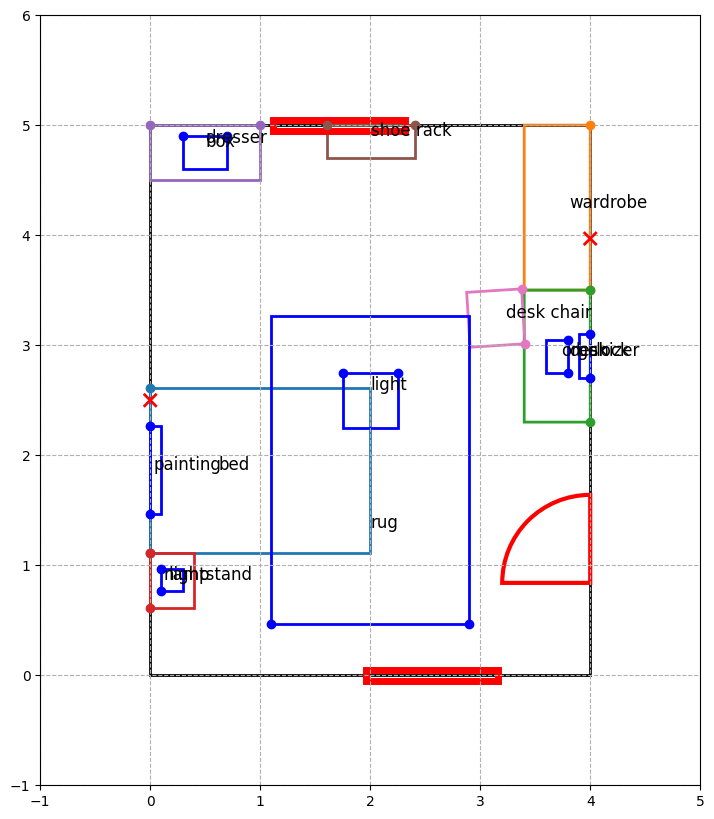

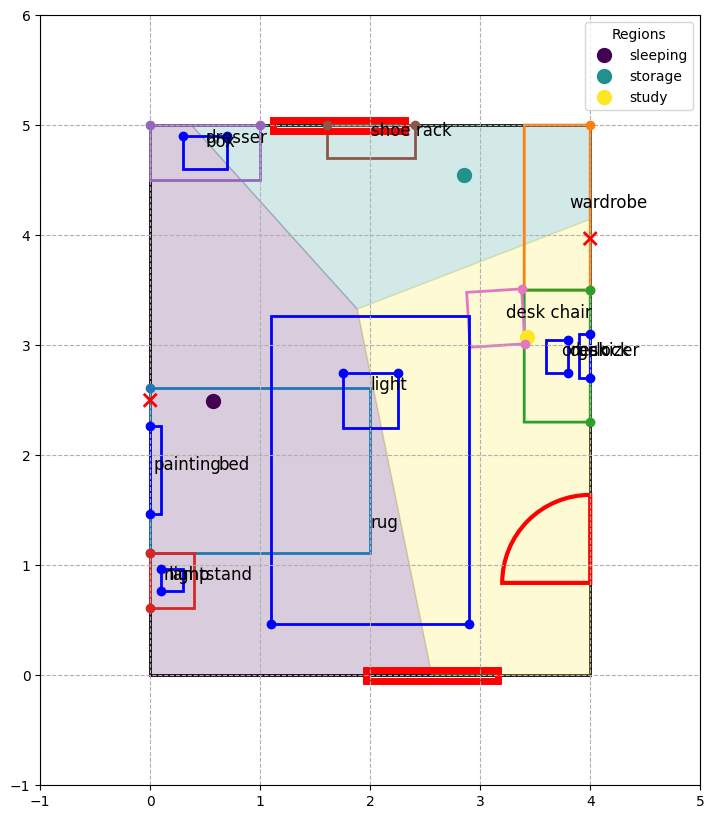

In [46]:
import string

dictionary = {}
ints = 0

dictionary['prompt'] = scene_descriptor
dictionary['room_width'] = room.width
dictionary['room_length'] = room.length

# Function to add objects to dictionary with unique names
def add_objects_to_dict(object_list, ints = 0):
    for obj in object_list:
        if obj.name in dictionary.keys():
            object_name = obj.name + str(ints)
            ints += 1
        else:
            object_name = obj.name
        dictionary[object_name] = {
            'position': obj.position,
            'width': obj.width,
            'length': obj.length
        }

add_objects_to_dict(room.moving_objects)
add_objects_to_dict(room.fixed_objects)
add_objects_to_dict(room.tertiary_objects)

# Add style information
dictionary['style'] = STYLEoutput.choices[0].message.content

# Generate a random filename
res = ''.join(random.choices(string.ascii_letters, k=3))

# Create the folder if it doesn't exist
folder_path = "Result_txt/" + res
os.makedirs(folder_path, exist_ok=True)

# Save the dictionary to a text file
file_path = os.path.join(folder_path, f"{res}.txt")
with open(file_path, 'w') as file:
    for key, value in dictionary.items():
        file.write(f"{key}: {value}\n")

# Save the plot as an image
image_path = os.path.join(folder_path, f"{res}_0.png")
image_path2 = os.path.join(folder_path, f"{res}_1.png")

room.draw()
plt.savefig(image_path)

room.draw(draw_regions = True)
plt.savefig(image_path2)

In [47]:
print("File saved to: ", file_path)

File saved to:  Result_txt/xgv/xgv.txt


## Final Plots

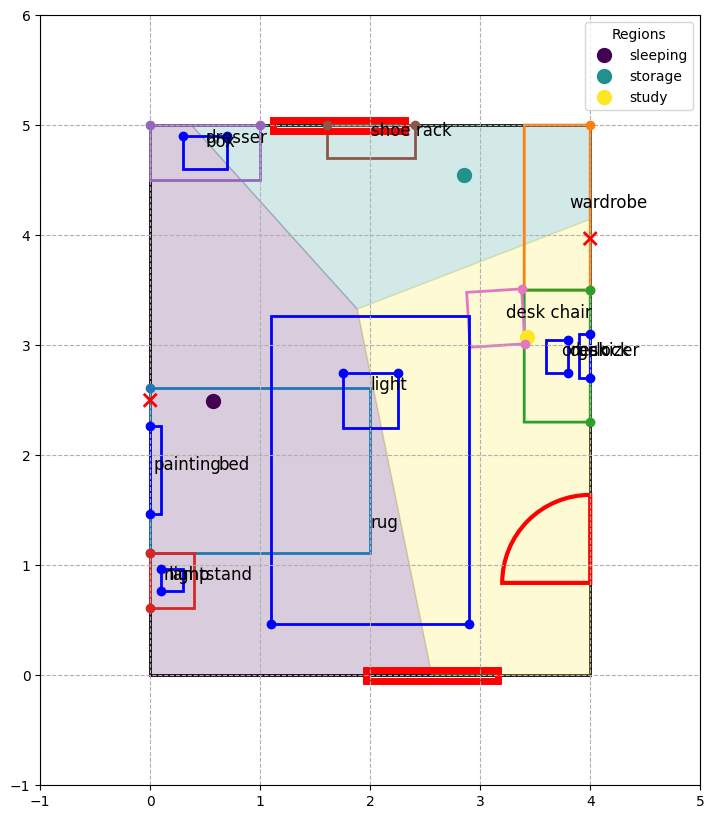

In [48]:
room.draw(draw_regions = True) # uncomment for all objects and regions
#room.draw(level = 0, arrows = True, key = True) # uncomment for primary + secondary objects labelled
#room.draw(level = 1, arrows = True, key = True) # uncomment for tertiary objects labelled

## Metric Evaluation

The Object Overlap Rate (OOR) is:  0.002207558625969884
The Out-Of-Bounds Rate (OOB) is:  0.005360500289053882


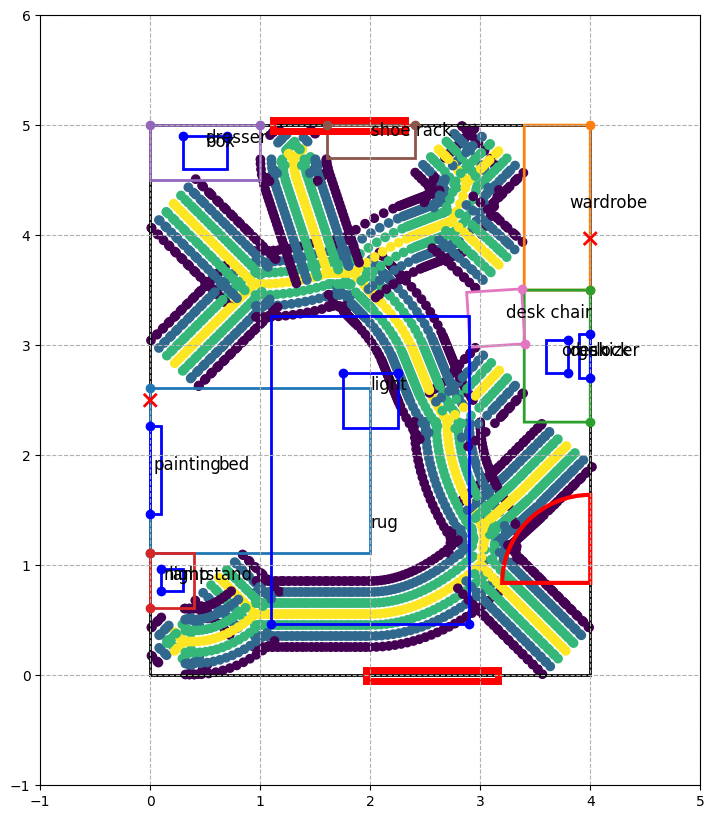

The Pathway Cost (C_p) is:  0.00010986545603129823


In [49]:
print("The Object Overlap Rate (OOR) is: ", OOR(room))
print("The Out-Of-Bounds Rate (OOB) is: ", OOB(room))
print("The Pathway Cost (C_p) is: ", pathway_cost(room))